In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np 
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import chi2

- I want the ML to take as input 17 parameters corresponding to $[ \{ \alpha_i \}, \Omega_m, \Omega_m h^2 ]$ and to output the luminosity distance of the SN as a function of z, i.e. $d_L(z)$.
- In practice what I want is the ML to output an array of $d_L$, one of every bin in z. Therefore: $input = 1 \times 17$ and $output=1 \times N_{zbins}$.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.manual_seed(13)

# Load and normalize data

In [4]:
def load_data_as_tensors(filename):
    keys = []
    values = []
    with h5py.File(filename, 'r') as hf:
        for group_name in hf.keys():
            key = hf[group_name]['input_cosmo'][:]
            value = hf[group_name]['LogdL'][:]
            keys.append(key)
            values.append(value)

    keys = np.array(keys)
    values = np.array(values)
    
    # Convert lists to PyTorch tensors
    train_x = torch.tensor(keys, dtype=torch.float32)  # Assuming keys are numeric
    train_y = torch.tensor(values, dtype=torch.float32)
    
    return train_x, train_y

- The Dataset is an abstraction to be able to load and process each sample of your dataset lazily, while the DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc.
  
  https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017

In [5]:
# data_x is a tensor that contains all the cosmo parameter input vectors
# data_y is a tensor that contains all the output of logdL for each redshift bin and each combination of cosmo param input

data_x, data_y = load_data_as_tensors('LogdL_trial.h5')
dataset = TensorDataset(data_x, data_y)

In [6]:
## Split the data into training, validation and testing sets
total_size = len(dataset)
train_size = int(0.6 * total_size)  
val_size = int(0.3 * total_size)    
test_size = total_size - train_size - val_size  

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

- Before I use the data, i need to normalize it.

In [7]:
# Extract training data from DataLoader object

train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

for data, labels in train_loader1:
    
    train_x_mean = data.mean(dim=0)
    train_x_std = data.std(dim=0)
    
    train_y_mean = labels.mean(dim=0)
    train_y_std = labels.std(dim=0)

# Define helper function that performs the data normalization
def helper_normalizer(data, mean, std):
    return (data - mean) / std
    
def normalize_data(dataset, mean_x, std_x, mean_y, std_y):
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    for data, labels in loader:
        norm_data_x = helper_normalizer(data, mean_x, std_x)
        norm_data_y = helper_normalizer(labels, mean_y, std_y)
    return norm_data_x, norm_data_y

# Normalize data tensors

norm_train_x, norm_train_y = normalize_data(train_dataset, train_x_mean, train_x_std, train_y_mean, train_y_std)
norm_val_x, norm_val_y = normalize_data(val_dataset, train_x_mean, train_x_std, train_y_mean, train_y_std)
norm_test_x, norm_test_y = normalize_data(test_dataset, train_x_mean, train_x_std, train_y_mean, train_y_std)
   
# Create new datasets with normalized data
train_dataset_normalized = TensorDataset(norm_train_x, norm_train_y)
val_dataset_normalized = TensorDataset(norm_val_x, norm_val_y)
test_dataset_normalized = TensorDataset(norm_test_x, norm_test_y)

# Create data loaders for each of the new normalized datasets
# Split in batches
batch_size = 32
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False)


    

In [8]:
for data, label in train_loader:
    print('data')
    print(data.shape, torch.std_mean(data,dim = None) )
    print('labels')
    print(label.shape, torch.std_mean(label, dim=None))
    break

data
torch.Size([32, 4]) (tensor(0.9759), tensor(0.0822))
labels
torch.Size([32, 500]) (tensor(0.7996), tensor(-0.0718))


# The NN

In [9]:
## Here I define an affine layer which will take care of the data normalization. 

class Affine(nn.Module):
    def __init__(self):
        super(Affine,self).__init__()
        self.gain = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.gain * x + self.bias
        

In [10]:
## Residual block - following the diagram in original ref: https://arxiv.org/pdf/1512.03385
## Each block will have two linear layers.
## The second activation is applied after I sum with the skip connection: ACT( F(x) + x )
class ResBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(ResBlock,self).__init__()
        if in_size != out_size:
            self.skip = nn.Linear(in_size, out_size, bias=False)
        else:
            self.skip = nn.Identity()
            
        self.linear1 = nn.Linear(in_size, out_size)
        self.linear2 = nn.Linear(out_size, out_size)

        self.norm1 = Affine()
        self.norm2 = Affine()

        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        
    def forward(self,x):
        xskip = self.skip(x)
        # x = self.act1(self.norm1(self.linear1(x)))
        # x = self.norm2(self.linear2(x))
        
        x = self.act1(self.linear1(self.norm1(x)))
        x = self.linear2(self.norm2(x))
        
        out = self.act2(x + xskip)
        return out
        
        

- Be careful with the definition of ModuleList. .modules() is a function defined under the class nn.Module, so I cannot reuse that name for a different method in my class definition.

In [11]:
class ResMLP(nn.Module):
    def __init__(self, input_dim, output_dim, block_nums):
        super(ResMLP,self).__init__()
        
        # Pytorch list that saves the different layers. These layers are not connected in a NN yet.
        # self.modules = nn.ModuleList()
        
        # Activation function to use
        self.act = nn.ReLU()
        
        # self.block = ResBlock(input_dim, input_dim)
        # Write a for loop that controls how many ResBlocks I include in my full network
        # for i in range(block_nums):
        #     self.modules.append(self.block)
        
        self.mymodules = nn.ModuleList([ResBlock(input_dim, input_dim) for _ in range(block_nums)])   
        
        # The last layer I append in the nn.ModuleList is the fully connected linear layer (output layer of my NN)
        self.mymodules.append(nn.Linear(input_dim, output_dim))
        
    def forward(self,x):
        ## I need to add one layer here to embed my input vector to the bigger internal space 
        # Connect the different blocks in the NN
        for block in self.mymodules[:-1]:
            x = self.act(block(x))
        # Pass the output through the final fully connected linear layer
        out = self.mymodules[-1](x)
        
        return out                 


# Training

In [12]:
## Training 
model = ResMLP(4,500,1)
model.to(device)
epochs = 50
train_losses = []
val_losses = []
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

In [13]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2544

In [14]:
for data, labels in train_loader:
    data, labels = data.to(device), labels.to(device)
    outputs = model(data)
    print(criterion(outputs,labels))
    break

tensor(1.5469, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
# ## Printing the initialization values of weights and biases
# def print_initial_parameters(model):
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f"Parameter: {name}, Initial value: {param.data}")

# print_initial_parameters(model)


- Note: When I use the validation data during the training of my model, I want to set model.eval() such that the NN does not use this data to train the model. I also want to set torch.no_grad(), so that pytorch does not store the outputs of the activation functions -- therefore saving RAM.

In [16]:
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)  
        loss = criterion(outputs, labels)       
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        # # Check gradients for NaNs
        # nan_found = False
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         if torch.isnan(param.grad).any():
        #             print(f"NaNs found in gradients of {name} during training")
        #             nan_found = True
        #             break
        
        # if nan_found:
        #     continue
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * data.size(0)
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [10/50], Train Loss: 1.1641, Val Loss: 1.2380
Epoch [20/50], Train Loss: 1.1614, Val Loss: 1.2352
Epoch [30/50], Train Loss: 1.1588, Val Loss: 1.2324
Epoch [40/50], Train Loss: 1.1562, Val Loss: 1.2297
Epoch [50/50], Train Loss: 1.1537, Val Loss: 1.2271


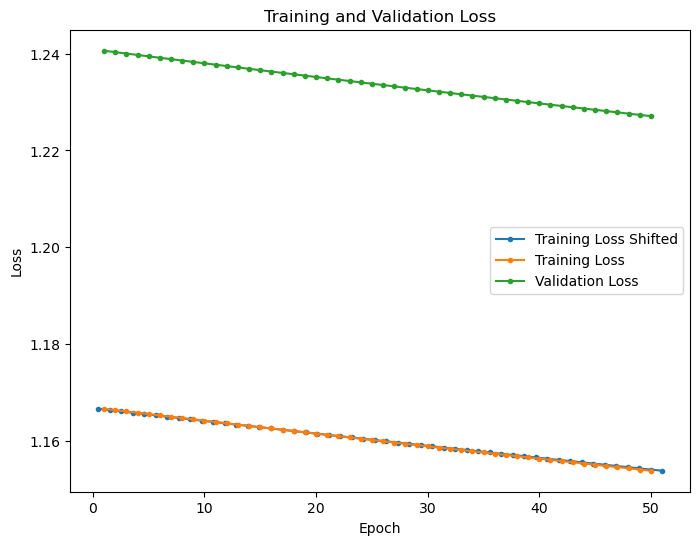

In [17]:
# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, len(train_losses) + 1), train_losses, marker='.', label='Training Loss Shifted')
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='.', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='.', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Testing

- I can use MSE to assess the goodness of fit for the output of my model compared with the labels of the test data.

In [18]:
## Testing
model.eval()
test_loss = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        predictions = model(data)
        loss = nn.MSELoss()(predictions, labels)
        test_loss += loss.item() 
        
mse_loss = test_loss / len(val_dataset)
print(f"Mean Squared Error: {mse_loss:.4f}")

Mean Squared Error: 0.0128


- I can use $\chi^2$ test to check the goodness of fit for the outputs of my model. The problem with this is that some entries of my labels are zero.
  
  $\chi^2 = \sum \frac{\left( observed - expected \right)^2}{expected}$

In [26]:
model.eval()
chi_sq = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        pred = model(data)
        res = pow((pred - labels), 2)
        if torch.count_nonzero(labels) != labels.numel():
            continue
        
        chi_sq += torch.sum(torch.div(res, labels))
        #print(chi_sq.shape)
     
chi_sq = chi_sq.item()
print(f"Chi-squared statistic: {chi_sq:.4f}")
    


Chi-squared statistic: -2154.6802


In [25]:
model.eval()
chi_sq = 0
total_samples = 0

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        pred = model(data)
        res = (pred - labels) ** 2
        
        # Check if any expected value (label) is zero and skip if true
        if torch.count_nonzero(labels) != labels.numel():
            continue
        
        chi_sq += torch.sum(res / labels)
        total_samples += data.size(0)
     
chi_sq = chi_sq.item()

# Degrees of freedom: number of elements per sample - 1, multiplied by the number of valid samples
num_elements_per_sample = labels.size(1)
df = (num_elements_per_sample - 1) * total_samples

# Calculate p-value
p_value = 1 - chi2.cdf(chi_sq, df)

print(f"Chi-squared statistic: {chi_sq:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value > 0.05:
    print("The model's fit is considered good (fail to reject the null hypothesis).")
else:
    print("The model's fit is considered poor (reject the null hypothesis).")


Chi-squared statistic: -2154.6802
P-value: 1.0000
The model's fit is considered good (fail to reject the null hypothesis).
